In [ ]:
!pip install tf-nightly-gpu-2.0-preview
!pip install 'tensorflow-hub == 0.4'

ERROR: Could not find a version that satisfies the requirement tf-nightly-gpu-2.0-preview (from versions: none)
ERROR: No matching distribution found for tf-nightly-gpu-2.0-preview
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-hub
    Found existing installation: tensorflow-hub 0.13.0
    Uninstalling tensorflow-hub-0.13.0:
      Successfully uninstalled tensorflow-hub-0.13.0


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import tensorflow_hub as hub
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

TensorFlow includes a special feature of image recognition and these images are stored in a specific folder. With relatively same images, it will be easy to implement this logic for security purposes.

In [ ]:
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Version:  2.12.0
Eager mode:  True
Hub version:  0.4.0
GPU is available


Next we extract the Dataset of images for training and testing

In [ ]:
zip_file = tf.keras.utils.get_file(origin='https://storage.googleapis.com/plantdata/PlantVillage.zip', fname='PlantVillage.zip', extract=True)

856839084/856839084 [==============================] - 11s 0us/step


In [ ]:
data_dir = os.path.join(os.path.dirname(zip_file), 'PlantVillage')
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')

In [ ]:
import time
import os
from os.path import exists
def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + " files"
print('Total images for training :', count(train_dir))
print('Total images for validation :', count(validation_dir))

Total images for training : /root/.keras/datasets/PlantVillage/train : 43444 files
Total images for validation : /root/.keras/datasets/PlantVillage/validation : 10861 files


In [ ]:
!!wget https://github.com/Indrani200/Mini_Project/archive/main.zip
!unzip main.zip;

Archive:  main.zip
acffa72446bbb1dc53093e697343ceab2dd3dde8
replace Mini_Project-main/categories.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Mini_Project-main/categories.json  


In [ ]:
import json
with open('Mini_Project-main/categories.json', 'r') as f:
    cat_to_name = json.load(f)
    classes = list(cat_to_name.values())
print (classes)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

In [ ]:
print('Number of classes:',len(classes))

Number of classes: 38


In [ ]:
module_selection = ("inception_v3", 299, 2048)
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))
BATCH_SIZE = 64

Using https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4 with input size (299, 299) and output dimension 2048


In [ ]:
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    shuffle=False,
    seed=42,
    color_mode="rgb",
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)
do_data_augmentation = True
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen
train_generator = train_datagen.flow_from_directory(
    train_dir,
    subset="training",
    shuffle=True,
    seed=42,
    color_mode="rgb",
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)


Found 10861 images belonging to 38 classes.
Found 43444 images belonging to 38 classes.


In [ ]:
tf.Tensor._USE_EQUALITY = False
feature_extractor = hub.KerasLayer(MODULE_HANDLE,input_shape=IMAGE_SIZE+(3,),output_shape=[FV_SIZE])

In [ ]:
do_fine_tuning = False
if do_fine_tuning:
  feature_extractor.trainable = True
  for layer in base_model.layers[-30:]:
    layer.trainable =True
else:
  feature_extractor.trainable = False

In [ ]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.summary()

Building model with https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 38)                19494     
                                                                 
Total params: 22,871,366
Trainable params: 1,068,582
Non-trainable params: 21,802,784
_______________

In [ ]:
LEARNING_RATE = 0.001
model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE),
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [ ]:
EPOCHS=5
history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

<ipython-input-21-48408ca2c4d6>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/5
678/678 [==============================] - 1053s 2s/step - loss: 1.1274 - accuracy: 0.7492 - val_loss: 0.6812 - val_accuracy: 0.8671
Epoch 2/5
489/678 [====================>.........] - ETA: 4:26 - loss: 0.6984 - accuracy: 0.8524

Plotting accuracy and loss graphs

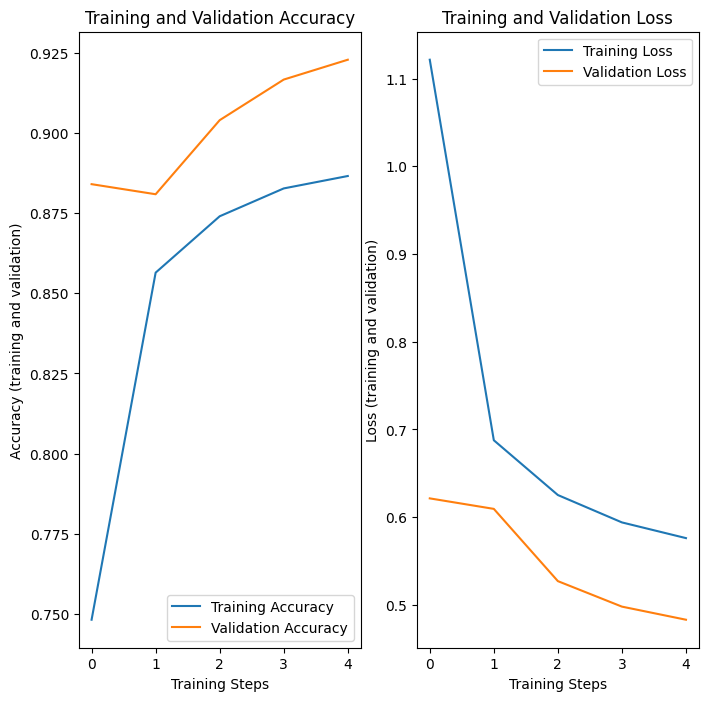

In [ ]:
import matplotlib.pylab as plt
import numpy as np
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

In [ ]:
import cv2
import itertools
import random
from collections import Counter
from glob import iglob
def load_image(filename):
    img = cv2.imread(os.path.join(data_dir, validation_dir, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    return img
def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: Tomato___Leaf_Mold, file: Tomato___Leaf_Mold/c661bd24-6fcf-4802-9010-68ef6e2e7fa8___Crnl_L.Mold 6644.JPG
1/1 [==============================] - 0s 29ms/step
PREDICTED: class: Tomato___Leaf_Mold, confidence: 0.890724
Pesticide/ to be used Mancozeb


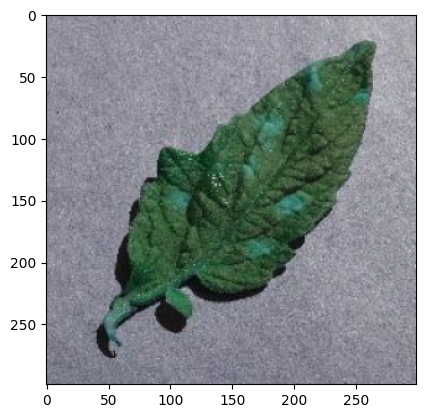

<Figure size 640x480 with 0 Axes>

SOURCE: class: Pepper,_bell___healthy, file: Pepper,_bell___healthy/030eee8e-5db2-4596-8ebc-6ab9b2fec504___JR_HL 5993.JPG
1/1 [==============================] - 0s 32ms/step
PREDICTED: class: Pepper,_bell___healthy, confidence: 0.954527
Pesticide/ to be used Methyl bromide


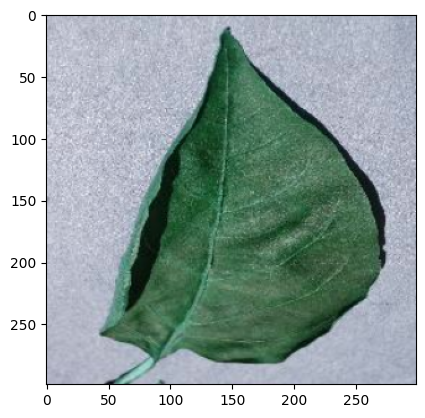

SOURCE: class: Pepper,_bell___healthy, file: Pepper,_bell___healthy/8665928b-77f2-483b-88eb-c7c08b3a6bde___JR_HL 7938.JPG
1/1 [==============================] - 0s 29ms/step
PREDICTED: class: Pepper,_bell___healthy, confidence: 0.809703
Pesticide/ to be used Methyl bromide


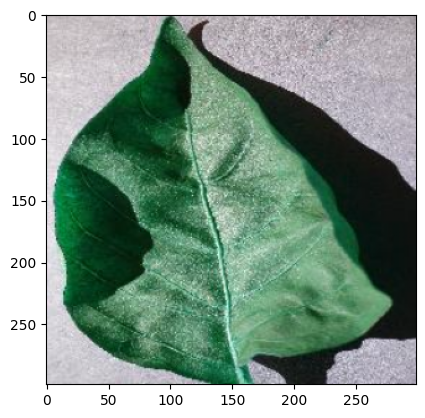

<Figure size 640x480 with 0 Axes>

SOURCE: class: Grape___Black_rot, file: Grape___Black_rot/82557506-a1bd-48eb-af05-af9271673fd2___FAM_B.Rot 3480.JPG
1/1 [==============================] - 0s 51ms/step
PREDICTED: class: Tomato___Late_blight, confidence: 0.354323
Pesticide/ to be used Chlorothalonil


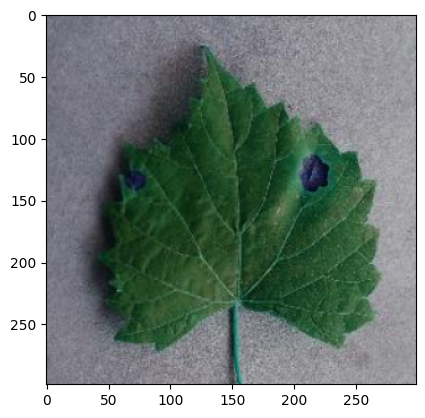

<Figure size 640x480 with 0 Axes>

SOURCE: class: Blueberry___healthy, file: Blueberry___healthy/40ca4fe4-5aba-4ee4-b219-27aa8fbe3fe5___RS_HL 5038.JPG
1/1 [==============================] - 0s 115ms/step
PREDICTED: class: Blueberry___healthy, confidence: 0.847929
Pesticide/ to be used Neem oil sprays


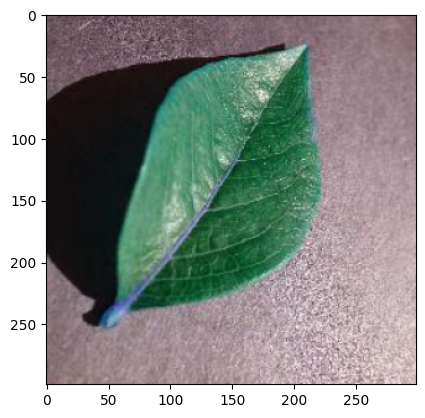

<Figure size 640x480 with 0 Axes>

SOURCE: class: Corn_(maize)___Common_rust_, file: Corn_(maize)___Common_rust_/RS_Rust 2113.JPG
1/1 [==============================] - 0s 49ms/step
PREDICTED: class: Corn_(maize)___Common_rust_, confidence: 0.999170
Pesticide/ to be used pyraclostrobin


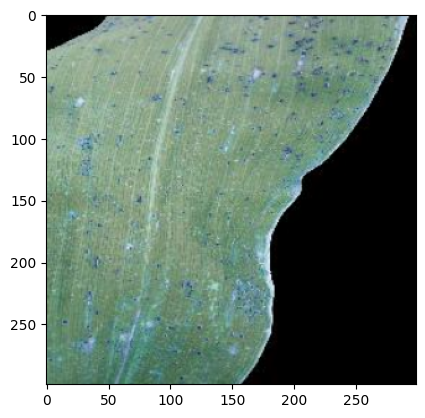

<Figure size 640x480 with 0 Axes>

SOURCE: class: Tomato___Tomato_Yellow_Leaf_Curl_Virus, file: Tomato___Tomato_Yellow_Leaf_Curl_Virus/f45631e7-854d-4577-9766-86877156749c___UF.GRC_YLCV_Lab 02291.JPG
1/1 [==============================] - 0s 59ms/step
PREDICTED: class: Tomato___Tomato_Yellow_Leaf_Curl_Virus, confidence: 0.993259
Pesticide/ to be used azadirachtin (Neem)


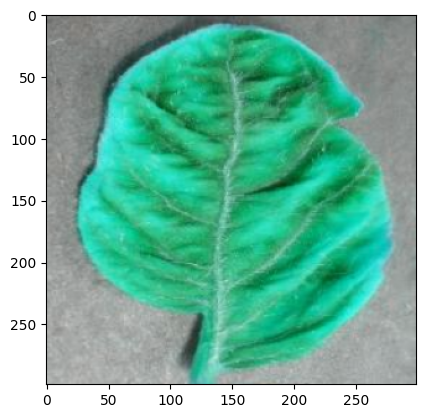

<Figure size 640x480 with 0 Axes>

SOURCE: class: Grape___Leaf_blight_(Isariopsis_Leaf_Spot), file: Grape___Leaf_blight_(Isariopsis_Leaf_Spot)/88a40dd6-6598-4b9a-9303-4757546e3d9d___FAM_L.Blight 1583.JPG
1/1 [==============================] - 0s 93ms/step
PREDICTED: class: Tomato___Septoria_leaf_spot, confidence: 0.586143
Pesticide/ to be used chlorothalonil


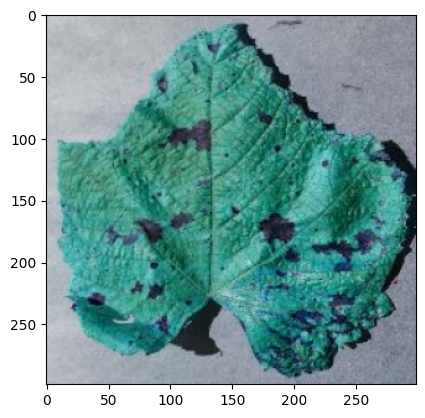

<Figure size 640x480 with 0 Axes>

SOURCE: class: Peach___healthy, file: Peach___healthy/eb1ea7cf-1cf2-460a-9a68-d97f1b6ccca0___Rutg._HL 3748.JPG
1/1 [==============================] - 0s 96ms/step
PREDICTED: class: Peach___healthy, confidence: 0.956764
Pesticide/ to be used Phosmet


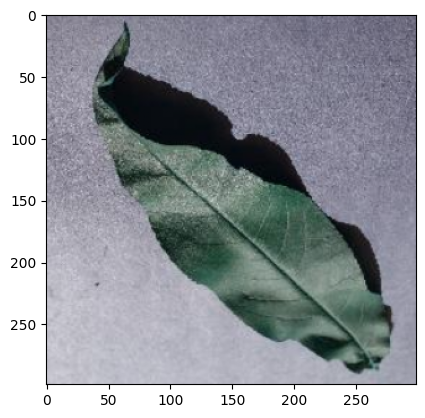

<Figure size 640x480 with 0 Axes>

SOURCE: class: Soybean___healthy, file: Soybean___healthy/6aecad2f-ab1d-4d44-b95d-b8fcac69a6dc___RS_HL 6201.JPG
1/1 [==============================] - 0s 140ms/step
PREDICTED: class: Soybean___healthy, confidence: 0.995140
Pesticide/ to be used Baythroid XL


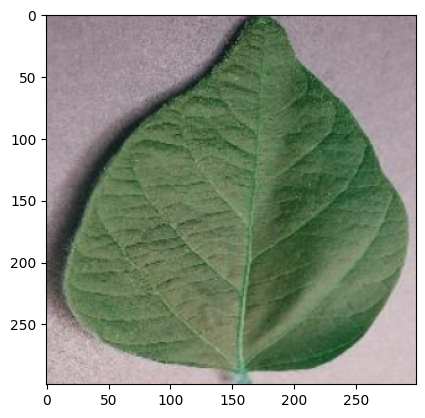

<Figure size 640x480 with 0 Axes>

In [ ]:
import json
with open('Mini_Project-main/fertile.json') as file:
    data= json.load(file)
for idx, filename in enumerate(random.sample(validation_generator.filenames, 10)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    print("Pesticide/ to be used",data[list(prediction.keys())[0]])
    plt.imshow(img)
    plt.figure(idx)
    plt.show()